# Prepare vido frames

In [1]:
!pip install progress

  Preparing metadata (setup.py) ... done
  Created wheel for progress: filename=progress-1.6-py3-none-any.whl size=9610 sha256=6124f15261720be895ee5fa50e817e26e63ecc363b0350f31749d3eb6648770c
  Stored in directory: /root/.cache/pip/wheels/a2/68/5f/c339b20a41659d856c93ccdce6a33095493eb82c3964aac5a1
Successfully built progress


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import cv2
import torch
#torch.cuda.empty_cache()
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from progress.bar import IncrementalBar

In [4]:
annotations_file = "/content/drive/MyDrive/slovo/SLOVO_DF_SHORT.tsv" #"/home/jupyter/mnt/s3/rsl-videos/slovo/slovo_annotations/SLOVO_DATAFRAME.tsv"
video_dir = "/content/drive/MyDrive/slovo/animals" #"/home/jupyter/mnt/s3/rsl-videos/slovo/slovo"
dataset_dir = "/content/drive/MyDrive/slovo/animalsdataset" # "/home/jupyter/mnt/s3/rsl-videos/slovo/dataset"
IMG_SIZE = 224

In [5]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

def load_video(path, begin, end, base_name, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frame_index=begin
    i = 0
    try:
        while True and frame_index <= end:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # convert to grayscale
            frame_name = f'{base_name}_{i}.png'
            cv2.imwrite(frame_name, frame)
            frame_index+=1
            i+=1
    finally:
        cap.release()


In [6]:
video_labels = pd.read_csv(annotations_file, sep='\t')
video_labels.head(5)

,Unnamed: 0,attachment_id,text,begin,end
0,0,8f4d3be1-3a09-4d76-94ef-f8b1dbfa686b,пингвин,29,100
1,1,4f9e3cb5-b9de-48bc-a51d-875b8fea8e10,пингвин,21,79
2,2,1de7b5b0-ce08-419f-aeed-e7e480da953d,пингвин,7,59
3,3,72f70640-6931-4f57-8c72-a68e48032cfb,пингвин,22,87
4,4,6933a0f1-a0e1-48d8-91be-b445ca6c80ce,пингвин,9,64


In [7]:
labels_cnt = video_labels.groupby('text').size().to_dict()
print(labels_cnt)
# 75 - train, 15 - val, 10 - test

{'бабочка': 20, 'бегемот': 20, 'бык': 20, 'дельфин': 20, 'динозавр': 20, 'жираф': 20, 'змея': 20, 'козел': 20, 'корова': 20, 'кролик': 20, 'курица': 20, 'лебедь': 20, 'лев': 20, 'лиса': 20, 'лось': 20, 'лягушка': 20, 'медведь': 20, 'медуза': 20, 'мышь': 20, 'обезьяна': 20, 'орел': 20, 'павлин': 20, 'паук': 20, 'пингвин': 20, 'птица': 20, 'пчела': 20, 'свинья': 20, 'слон': 20, 'собака': 20, 'тигр': 20}


In [8]:
test_counter = dict()
val_counter = dict()
train_counter = dict()

#i=0
bar = IncrementalBar('Countdown', max = len(video_labels))
for idx, row in video_labels.iterrows():
    attachment_id = row['attachment_id']
    filename = os.path.join(video_dir, attachment_id+".mp4")
    label = row['text']
    begin = row['begin']
    end = row['end']
    if label not in train_counter:
        dataset_type = 'train'
        train_counter[label] = 1
    elif train_counter[label] < labels_cnt[label]*0.75:
        dataset_type = 'train'
        train_counter[label] += 1
    elif label not in val_counter:
        dataset_type = 'val'
        val_counter[label] = 1
    elif val_counter[label] < val_counter[label]*0.25:
        dataset_type = 'val'
        val_counter[label] += 1
    elif label not in test_counter:
        dataset_type = 'test'
        test_counter[label] = 1
    else:
        dataset_type = 'test'
        test_counter[label] += 1
    dirname = os.path.join(dataset_dir , dataset_type, label, attachment_id)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    base_name = os.path.join(dataset_dir , dataset_type, label, attachment_id, attachment_id)
    load_video(path=filename,
             begin=begin,
             end=end,
             base_name=base_name,
             resize=(IMG_SIZE, IMG_SIZE)
             )
    bar.next()
    # i+=1
    # if i==1:
    #     break
bar.finish()

In [11]:
min_frame_cnt = 1000
for ds in os.listdir(dataset_dir):
  for animal in os.listdir(os.path.join(dataset_dir, ds)):
    for filename in os.listdir(os.path.join(dataset_dir, ds, animal)):
      frame_cnt = len(os.listdir(os.path.join(dataset_dir, ds, animal, filename)))
      if frame_cnt<min_frame_cnt:
        min_frame_cnt = frame_cnt
        min_file = os.path.join(dataset_dir, ds, animal, filename)

print(f"MIN FRAME COUNT: {min_frame_cnt}")
print(f"SHORTEST VIDEO: {min_file}")

MIN FRAME COUNT: 23
SHORTEST VIDEO: /content/drive/MyDrive/slovo/animalsdataset/train/змея/f90ca278-298b-4823-9ca7-73498531cb4e


In [13]:
image = cv2.imread(min_file+'/f90ca278-298b-4823-9ca7-73498531cb4e_5.png')
image.shape

(224, 224, 3)

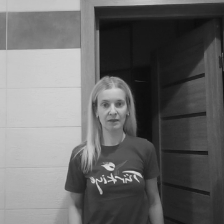

In [14]:
from google.colab.patches import cv2_imshow
cv2_imshow(image)